# 4. Model Evaluation

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

## Data preparation

In [2]:
file_path = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'

In [3]:
df = pd.read_csv(file_path)

In [4]:
# Check dataframe
df.sample(10)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
3182,Cadillac,CT6,2016,premium unleaded (required),404.0,6.0,AUTOMATIC,all wheel drive,4.0,"Luxury,High-Performance",Large,Sedan,26,18,1624,87465
3315,Oldsmobile,Cutlass Ciera,1992,regular unleaded,160.0,6.0,AUTOMATIC,front wheel drive,4.0,NaN,Midsize,Wagon,27,17,26,2000
6963,Pontiac,Montana,2005,regular unleaded,200.0,6.0,AUTOMATIC,all wheel drive,4.0,NaN,Midsize,Passenger Minivan,21,15,210,27700
8094,Dodge,RAM 250,1992,regular unleaded,230.0,8.0,MANUAL,four wheel drive,2.0,NaN,Large,Regular Cab Pickup,15,12,1851,2000
9745,Hyundai,Sonata,2017,regular unleaded,245.0,4.0,AUTOMATIC,front wheel drive,4.0,Performance,Midsize,Sedan,31,22,1439,26600
4873,Kia,Forte,2016,regular unleaded,173.0,4.0,AUTOMATIC,front wheel drive,4.0,"Hatchback,Performance",Compact,4dr Hatchback,33,25,1720,20390
7517,Nissan,Pathfinder,2015,regular unleaded,260.0,6.0,AUTOMATIC,front wheel drive,4.0,Crossover,Large,4dr SUV,27,20,2009,41560
4885,Kia,Forte,2017,regular unleaded,164.0,4.0,AUTOMATIC,front wheel drive,4.0,Hatchback,Compact,4dr Hatchback,34,25,1720,21990
10143,Suzuki,SX4,2013,regular unleaded,150.0,4.0,MANUAL,all wheel drive,4.0,"Crossover,Hatchback",Compact,4dr Hatchback,30,22,481,16999
3349,Mazda,CX-3,2017,regular unleaded,146.0,4.0,AUTOMATIC,all wheel drive,4.0,Crossover,Compact,4dr SUV,32,27,586,26240


In [5]:
# Define columns we want to keep
columns_to_keep = [
'Make',
'Model',
'Year',
'Engine HP',
'Engine Cylinders',
'Transmission Type',
'Vehicle Style',
'highway MPG',
'city mpg',
'MSRP'
]

# Keep only required columns for the project
df_filtered = df[columns_to_keep]

In [6]:
# Check missing values
missing_values = df_filtered.isnull().sum()
print(missing_values)

Make                  0
Model                 0
Year                  0
Engine HP            69
Engine Cylinders     30
Transmission Type     0
Vehicle Style         0
highway MPG           0
city mpg              0
MSRP                  0
dtype: int64


In [7]:
df_filtered = df_filtered.fillna(0)

In [8]:
df_filtered.columns = df_filtered.columns.str.replace(' ', '_').str.lower()

In [9]:
df_filtered.rename(columns={'msrp': 'price'}, inplace=True)

### Make price binary

In [10]:
mean_price = df_filtered['price'].mean()
mean_price

40594.737032063116

In [11]:
df_filtered['above_average'] = np.where(df_filtered['price'] > mean_price, 1, 0)

### Split the data

In [12]:
df_full_train, df_test = train_test_split(df_filtered, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [13]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [14]:
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values


In [15]:
print(f'Training set: {(df_train.shape[0]/len(df_filtered))*100} %')
print(f'Validation set: {(df_val.shape[0]/len(df_filtered))*100} samples')
print(f'Test set: {(df_test.shape[0]/len(df_filtered))*100} samples')

Training set: 59.99664260533826 %
Validation set: 20.00167869733087 samples
Test set: 20.00167869733087 samples


## Question 1 - ROC AUC feature importance

In [16]:
categorical = [
    'make',
    'model',
    'vehicle_style',
    'transmission_type'
]

In [17]:
numerical = [
    'year',
    'engine_hp',
    'highway_mpg',
    'city_mpg',
    'engine_cylinders']

In [18]:
auc_scores = {}

In [19]:
for feature in numerical:
    auc = roc_auc_score(df_train['above_average'], df_train[feature])
    if auc < 0.5:
        auc = roc_auc_score(df_train['above_average'], -df_train[feature])
    print(f"{feature}: {auc:.2f}")

year: 0.69
engine_hp: 0.92
highway_mpg: 0.63
city_mpg: 0.67
engine_cylinders: 0.77


## Question 2 - Training the model

In [20]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)


In [21]:
df_train.drop(['above_average', 'price'], axis=1, inplace=True)

df_val.drop(['above_average', 'price'], axis=1, inplace=True)
df_test.drop(['above_average', 'price'], axis=1, inplace=True)

In [22]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
# solver='lbfgs' is the default solver in newer version of sklearn
# for older versions, you need to specify it explicitly
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [23]:
y_pred = model.predict(X_val)

In [24]:
# Predicting the probability for the positive class
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Calculating AUC
auc = roc_auc_score(y_val, y_pred_proba)

# Display AUC rounded to 3 decimal places
print(f"The AUC of the model on the validation dataset is: {round(auc, 3)}")

The AUC of the model on the validation dataset is: 0.98


## Question 3 - Precision and Recall

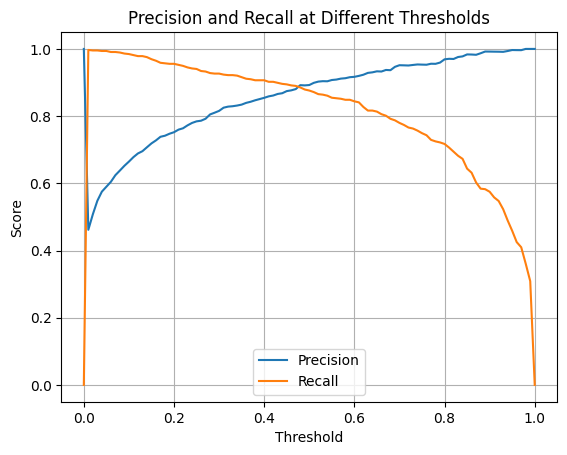

Precision and recall intersect approximately at threshold: 0.47


In [25]:
# Define thresholds
thresholds = np.arange(0.0, 1.01, 0.01)  # from 0.0 to 1.0 with step 0.01

# Calculate precision and recall for each threshold
precisions = []
recalls = []

for threshold in thresholds:
    y_pred_binarized = (y_pred_proba >= threshold).astype(int)
    precision, recall, _ = precision_recall_curve(y_val, y_pred_binarized)
    precisions.append(precision[1])  # appending the precision for positive class
    recalls.append(recall[1])  # appending the recall for positive class

# Plotting
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall at Different Thresholds')
plt.legend()
plt.grid(True)
plt.show()

# Find the threshold where precision and recall intersect
intersect_threshold_index = np.argwhere(np.isclose(precisions, recalls, atol=0.01)).flatten()
if intersect_threshold_index.size > 0:
    intersect_threshold = thresholds[intersect_threshold_index[0]]
    print(f"Precision and recall intersect approximately at threshold: {intersect_threshold:.2f}")
else:
    print("Precision and recall do not intersect")

## Question 4 - F1 score

In [26]:
max_f1 = 0
best_threshold = 0

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)  # Predict class labels based on threshold
    f1 = f1_score(y_val, y_pred)  # Calculate F1 Score
    
    # Update max F1 Score and best threshold if current F1 Score is better
    if f1 > max_f1:
        max_f1 = f1
        best_threshold = threshold

print(f"Maximum F1 Score: {max_f1:.4f} at Threshold: {best_threshold:.3f}")

Maximum F1 Score: 0.8887 at Threshold: 0.480


In [27]:
# Manual F1 calculation 

max_f1 = 0
best_threshold = 0

for threshold in thresholds:
    # Predict class labels based on threshold
    y_pred = np.where(y_pred_proba >= threshold, 1, 0)
    
    # Calculate precision and recall
    precision, recall, _ = precision_recall_curve(y_val, y_pred)
    
    if len(precision) > 1:
        precision = precision[1]
        recall = recall[1]
    
    # Calculate F1 Score
    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0
    
    # Update max F1 Score and best threshold if current F1 Score is better
    if f1 > max_f1:
        max_f1 = f1
        best_threshold = threshold

print(f"Maximum F1 Score: {max_f1:.4f} at Threshold: {best_threshold:.3f}")

Maximum F1 Score: 0.8887 at Threshold: 0.480


## Question 5 - 5-Fold CV

In [38]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores = []

for train_index, val_index in kf.split(df_full_train):
    
    # Split the data
    df_train = df_full_train.iloc[train_index]
    df_val = df_full_train.iloc[val_index]
    
    y_train = df_train.above_average.values
    y_val = df_val.above_average.values
    
    df_train = df_train.drop(['above_average', 'price'], axis=1)
    df_val = df_val.drop(['above_average', 'price'], axis=1)

    dv = DictVectorizer(sparse=False)
    
    train_dict = df_train[categorical + numerical].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    val_dict = df_val[categorical + numerical].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    # Train the model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    # Predict and evaluate the model
    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    auc_scores.append(auc)

# Calculate the standard deviation of AUC scores
auc_std_dev = np.std(auc_scores)
print(f'The standard deviation of AUC scores: {round(auc_std_dev,3)}')

The standard deviation of AUC scores: 0.003


## Question 6 - Hyperparemeter Tuning

In [56]:
C_values = [0.01, 0.1, 0.5, 10]

kf = KFold(n_splits=5, shuffle=True, random_state=1)

for c_value in C_values:

        for train_index, val_index in kf.split(df_full_train):

            # Split the data
            df_train = df_full_train.iloc[train_index]
            df_val = df_full_train.iloc[val_index]

            y_train = df_train.above_average.values
            y_val = df_val.above_average.values

            df_train.drop(['above_average', 'price'], axis=1)
            df_val.drop(['above_average', 'price'], axis=1)
            dv = DictVectorizer(sparse=False)

            train_dict = df_train[categorical + numerical].to_dict(orient='records')
            X_train = dv.fit_transform(train_dict)

            val_dict = df_val[categorical + numerical].to_dict(orient='records')
            X_val = dv.transform(val_dict)

            # Train the model
            model = LogisticRegression(solver='liblinear', C=c_value, max_iter=1000)
            model.fit(X_train, y_train)

            # Predict and evaluate the model
            y_pred = model.predict_proba(X_val)[:, 1]
            auc = roc_auc_score(y_val, y_pred)

            auc_scores.append(auc)

        # Calculate the standard deviation of AUC scores
        auc_std_dev = np.std(auc_scores)
        auc_mean_dev = np.mean(auc_scores)
        print(f'C value: {c_value}')
        print(f'AUC mean value: {auc_mean_dev}')
        print(f'AUC std value: {auc_std_dev}')

C value: 0.01
AUC mean value: 0.970100461174728
AUC std value: 0.012238874639791716
C value: 0.1
AUC mean value: 0.970135698994183
AUC std value: 0.012115837883854286
C value: 0.5
AUC mean value: 0.9702887160602433
AUC std value: 0.012041645162758994
C value: 10
AUC mean value: 0.9705236041545807
AUC std value: 0.012042244099462267
